# Bias in Wikipedia Trends for Winners of 2018 U. S. House Congressional Winners
### Joshua Bone - UW DATA 512 - 12/9/2018

#### Overview

In this study I investigate trends in views and edits of Wikipedia pages for the winners of 2018 U. S. House Congressional races over the time period from January 1, 2018, to a few weeks after the midterm elections on November 6, 2018. I compare the average number of views and edits over time across political parties and levels of contestedness as determined by pre-election polling, to see if political party or level of contestedness leads to observable differences in the data trends.

This study is important because Wikipedia has a reputation as being a relatively unbiased source of information, and because it seems likely that many people use it as one of the first places to go to find out information about a political candidate. However, because anyone can make edits to the platform, it seems likely that both supporters and detractors of political candidates would use the platform to edit and portray the information in a way that is most beneficial to their side. While Wikipedia's [Protection Policy](https://en.wikipedia.org/wiki/Wikipedia:Protection_policy#extended) no doubt does much to prevent the site from being used as a mudslinging platform, a simple glance at the [revision history](https://en.wikipedia.org/w/index.php?title=Donald_Trump&offset=&limit=500&action=history) for Donald Trump's Wikipedia page (to use an obviously polarizing example), as well as the [Talk page](https://en.wikipedia.org/wiki/Talk:Donald_Trump) for that article, shows a near-constant back-and-forth of revisions and community discussion about what information should be shown, and where. 

#### Data
##### 2018 U.S. House Elections Ratings for Competitive Seats
Politician data was parsed from the table found on the [Wikipedia article] (https://en.wikipedia.org/wiki/United_States_House_of_Representatives_elections,_2018#Latest_published_ratings_for_competitive_seats). Because Wikipedia content may change over time, I have linked to a specific revision of this table that was current as of November 29, 2019. Although all 435 seats in the House were up for election during this cycle, this table contains only the 138 candidates whose election was determined by at least one polling source to be at least minimally contested.

Like all of Wikipedia's text content, this data is licensed under the [CC-BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) license. 

##### Wikimedia Pageviews API
This API returns the number of times that a Wikipedia page was viewed during a specified time period. (Details and example API calls can be found [here](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews)). The data from this API is licensed under the [CC-BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/).

I used this API to return the count of weekly views for each politician's Wikipedia page over the time period in question.

##### Wikipedia Revisions API
This API has a query module that returns, among other things, a history of revisions for a Wikipedia page, including the editor's username, the timestamp of the revision, and a comment explaining which changes were made. (Details and example API calls can be found [here](https://www.mediawiki.org/wiki/API:Query)). The data from this API is licensed under the [CC-BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/) license.

I used this API to return the revision history for each politician's Wikipedia page, which I then aggregated to find the count of weekly revisions for each page over the time period in question.

#### Research Questions and Hypotheses
##### Q1: How do trends in Wikipedia page views and edits vary over the course of an election cycle?

H1: My hypothesis was that there would be a steadily increasing buildup of activity with a peak occurring just after the election date.

##### Q2: Do trends in Wikipedia page views and edits vary between political parties?

H2: My hypothesis was that there would be similar trends between the two parties.

##### Q3: Do trends in Wikipedia page views and edits vary with how contested an election is believed to be?

H3: My hypothesis was that there would be a strong correlation, i.e. that elections that were perceived to be highly contested would result in more page views and edits.

#### Research

We begin by importing the tools we need for this notebook.

In [36]:
import csv, datetime, json, math, random, re, requests, sys
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

Since we will be processing HTML, we can save ourselves some pain by installing the [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/) module.

In [7]:
!pip install bs4 --user
from bs4 import BeautifulSoup

To ensure reproducibility of this notebook, we link to a specific revision of the Wikipedia page for the 2018 U. S. House elections.  

In [8]:
##CURRENT REVISIONS AS OF 11/29/2018
house_link = "https://en.wikipedia.org/w/index.php?title=2018_United_States_House_of_Representatives_elections&oldid=871279764"
house_soup = BeautifulSoup(requests.get(house_link).text)

The raw data is bundled within a "soup" of nested HTML tags. We process it to find the winning political party and the link to the politician's Wikipedia page. We also average the pre-election polling results to determine a level of contestedness for each race. Finally, we save these results to CSV.

In [9]:
def mapToContent(x):
  a = x.find('a', recursive=False)
  ret = x.text if a == None else a.text
  return re.sub(r"\[\d+\]", '', ret).strip()

house_table = house_soup.find('table', {'class':'wikitable sortable'})
house_headers = list(map(mapToContent, house_table.find('tbody').find('tr', {'valign':'bottom'}).findAll('th')))

row_regex = re.compile(r"\xa0")
def cleanRow(row):
  cols = [row.find('th')] + row.findAll('td')
  wiki_link = cols[-1].find('a')['href'][6:]
  return list(map(lambda x : re.sub(row_regex, ' ', x.text.strip()), cols)) + [wiki_link]

winning_party_regex = re.compile(r"(?:% |\()([A-Z])")
def winning_party(row):
  return re.search(winning_party_regex, row[-2]).group(1)

ratings_metric = {"Tossup":5, "Tilt":4, "Lean":3, "Likely":2, "Safe":1}
def contestedness(row):
  ratings = row[4:11]
  sum = 0
  for r in ratings:
    for metric in ratings_metric:
      if metric in r:
        sum = sum + ratings_metric[metric]
  return math.floor(sum / len(ratings))

house_rows = list(map(cleanRow, house_table.findAll('tr')[1:-1]))

HOUSE_CSV = "house.csv"
with open(HOUSE_CSV, 'w') as f:
  writer = csv.writer(f)
  writer.writerow(["Party", "Contestedness", "Wikipedia Page"])
  for row in house_rows:
    writer.writerow([winning_party(row), contestedness(row), row[-1]])

We read the data back in from CSV and peek at the first few rows to make sure it matches what we expect.

In [10]:
df = pd.read_csv(HOUSE_CSV)
df.head()

,Party,Contestedness,Wikipedia Page
0,R,3,Don_Young
1,D,2,Tom_O%27Halleran
2,D,2,Ann_Kirkpatrick
3,R,1,David_Schweikert
4,R,1,Debbie_Lesko


Before we call any APIs, we define our date range. The important date is Election Day, November 6, but it would be nice to examine trends over most of the year. We start on January 1st, 2018, a Monday. In order to facilitate grouping evenly by week, we choose November 25 as our end date, a Sunday.

In [11]:
START_DATE = datetime.date(2018, 1, 1)  # start date
END_DATE = datetime.date(2018, 11, 25)  # end date

For each Wikipedia page, we call the Pageviews API with our start and end dates, and save the daily views in JSON format. 

In [12]:
def date_format(date):
  return date.strftime("%Y%m%d00")
ENDPOINT_PGV = ('https://wikimedia.org/api/rest_v1/metrics/pageviews/'
                      'per-article/en.wikipedia/all-access/all-agents/'
                      '{page}/daily/{start}/{end}')
def call_pageviews_api(page):
  params = {'page' : page,'start' : date_format(START_DATE),'end' : date_format(END_DATE)}
  response = requests.get(ENDPOINT_PGV.format(**params)).json()
  return {item['timestamp']:item['views'] for item in response['items']}
PGV_JSON="house_pageviews_raw.json"
raw_json = {page: call_pageviews_api(page) for page in df['Wikipedia Page'].tolist()}
with open(PGV_JSON, "w") as f:
  f.write(json.dumps(raw_json))

For each Wikipedia page, we call the Wikipedia API to get the revisions. A few of the page titles have slightly different names in this API, so we make substitutions as necessary. We save the raw edit histories in JSON format.

In [13]:
URL = "https://en.wikipedia.org/w/api.php"
PARAMS = {"action": "query","prop": "revisions","rvlimit": 500,"rvprop": "timestamp",
    "format": "json","rvdir" : "newer","rvstart" : "2018-01-01T00:00:00Z"
}
substitutions = {
    "Mario_Diaz-Balart":"Mario_Díaz-Balart",
    "Andy_Barr_(U.S._politician)":"Andy_Barr_(American_politician)",
    "Michael_T._McCaul":"Michael_McCaul",
    "Tom_O%27Halleran": "Tom_O'Halleran"
}
def call_edits_api(page):
  if page in substitutions:
    page = substitutions[page]
  PARAMS["titles"] = page
  response = requests.get(url=URL, params=PARAMS).json()['query']['pages']
  id = list(response.keys())[0] #Each response contains a single page id
  return list(map(lambda r : r['timestamp'], response[id]['revisions']))

EDITS_JSON="house_edits_raw.json"
raw_json = {page: call_edits_api(page) for page in df['Wikipedia Page'].tolist()}
with open(EDITS_JSON, "w") as f:
  f.write(json.dumps(raw_json))

We read in the raw pageviews and edits data and print a randomly sampled item to make sure the data looks right.

In [34]:
with open(PGV_JSON, "r") as f:
  raw_pgv = json.load(f)

with open(EDITS_JSON, "r") as f:
  raw_edits = json.load(f)
  
print("Random item from raw pageviews (series of counts in daily buckets):")
rnd_view = random.choice(list(raw_pgv.items()))
print(rnd_view[0])
s = sorted(rnd_view[1].keys())
for i in range(0, 5):
    print("%s: %d, " % (s[i], rnd_view[1][s[i]]), end='')
print('etc.')
print("Random item from raw edits (series of timestamps):")
rnd_edit = random.choice(list(raw_edits.items()))
print(rnd_edit[0])
for i in range(0, 3):
    print(rnd_edit[1][i] + ", ", end='')
print('etc.')

Random item from raw pageviews (series of counts in daily buckets):
Anthony_Brindisi
2018010100: 111, 2018010200: 77, 2018010300: 33, 2018010400: 24, 2018010500: 23, etc.
Random item from raw edits (series of timestamps):
Chrissy_Houlahan
2018-06-27T20:07:38Z, 2018-07-11T20:59:48Z, 2018-08-01T15:48:21Z, etc.


The next step is to aggregate and average all of the pageviews and edits into weekly buckets and join with the party and contestedness data. We do this separately for each combination of party and contestedness, and save the results to JSON.

In [37]:
cPARTY = 'party'
cCONTESTEDNESS = 'contestedness'
cVIEWS = 'views'
cEDITS = 'edits'
cNUM_PAGES = 'number_of_pages'

def buckets_to_list(weekly_buckets):
  output = []
  for i in range(0, (END_DATE - START_DATE).days + 1, 7):
    w = date_format(START_DATE + datetime.timedelta(i))
    output.append(weekly_buckets[w] if w in weekly_buckets else 0)
  return output

def aggregate_weekly_edits(edit_history):
  output = defaultdict(int)
  for d in edit_history:
    d = datetime.datetime.strptime(d.split('T')[0], '%Y-%m-%d')
    w = date_format(d - datetime.timedelta(d.weekday()))
    output[w] += 1
  return dict(output)

def aggregate_weekly_views(daily_views):
  output = defaultdict(int)
  for i in range((END_DATE - START_DATE).days + 1):
    d = date_format(START_DATE + datetime.timedelta(i))
    w = date_format(START_DATE + datetime.timedelta(i - i % 7))
    if d in daily_views:
      output[w] += daily_views[d]
  return dict(output)

data_per_candidate = {}
with open(HOUSE_CSV) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count != 0:
          page = row[2]
          contestedness = row[1]
          party = row[0]
          data_per_candidate[page] = {cPARTY: party, cCONTESTEDNESS: contestedness}
        line_count += 1

for page in raw_edits:
  data_per_candidate[page][cEDITS] = buckets_to_list(aggregate_weekly_edits(raw_edits[page]))
for page in raw_pgv:
  data_per_candidate[page][cVIEWS] = buckets_to_list(aggregate_weekly_views(raw_pgv[page]))


def zavg(list_of_lists):
  return [round(sum(x)/len(list_of_lists), 4) for x in zip(*list_of_lists)]

def avg_where(parties, c_lvls, col):
  dpc = data_per_candidate
  matches = [dpc[p][col] for p in dpc if dpc[p][cCONTESTEDNESS] in c_lvls and dpc[p][cPARTY] in parties]
  return zavg(matches)

parties = ['R','D',"RD"]
combos = ['1','2','3','4','12','34','1234']
views = {p+c: avg_where(p,c,cVIEWS) for p in parties for c in combos}
edits = {p+c: avg_where(p,c,cEDITS) for p in parties for c in combos}

VIEWS_JSON = "views.json"
EDITS_JSON = "edits.json"
with open(VIEWS_JSON, 'w') as f:
  f.write(json.dumps(views))
with open(EDITS_JSON, 'w') as f:
  f.write(json.dumps(edits))

Read in the views and edits from file. Sample to verify data looks correct.

In [38]:
with open(VIEWS_JSON, "r") as f:
  views = json.load(f)
with open(EDITS_JSON, "r") as f:
  edits = json.load(f)
  
print("Random category from views (series of averaged weekly counts):")
print(random.choice(list(views.items())))
print()
print("Random category from edits (series of averaged weekly counts):")
print(random.choice(list(edits.items())))

Random category from views (series of averaged weekly counts):
('RD3', [528.4545, 865.6818, 877.1818, 810.1818, 774.1364, 638.9545, 613.7727, 689.5, 760.1818, 814.1364, 705.5455, 725.3636, 666.9545, 585.1364, 750.5909, 1785.5455, 556.5, 533.4091, 812.6364, 739.5909, 594.0455, 558.1364, 709.5455, 600.6364, 664.5909, 750.1818, 599.2727, 750.9091, 948.4091, 1308.6818, 1351.2273, 2937.4545, 996.5909, 1262.6364, 1423.2727, 1235.3182, 1006.6364, 1185.0455, 1279.6818, 2143.2273, 1811.4545, 3566.8182, 2400.9091, 2598.0909, 13125.7273, 3975.0909, 2911.0909])

Random category from edits (series of averaged weekly counts):
('RD2', [0.8537, 0.9024, 2.0244, 1.2439, 0.7073, 0.5366, 0.7561, 1.0732, 0.6585, 1.0488, 4.9268, 1.4146, 2.1951, 0.8537, 2.2195, 1.4634, 1.3902, 1.0732, 1.2439, 1.6585, 0.7317, 0.6341, 1.5122, 1.0732, 0.9756, 1.6829, 1.561, 4.0732, 1.8049, 1.439, 1.0976, 4.7805, 1.5122, 3.439, 0.878, 2.439, 1.7317, 1.2195, 1.1463, 1.0, 1.5366, 2.0, 1.6829, 5.0, 14.9512, 4.0488, 3.0244])


Assign each combination of party (R=Republican, D=Democrat, A=All), contestedness(1=Safe, 4=Highly Contested, etc), and type of interaction (v=views, e=edits) to its own variable to make it easy to work with.

In [39]:
  R1v, R2v, R3v, R4v, R12v, R34v, Rtotv = [views['R'+c] for c in combos]
D1v, D2v, D3v, D4v, D12v, D34v, Dtotv = [views['D'+c] for c in combos]
A1v, A2v, A3v, A4v, A12v, A34v, Atotv = [views['RD'+c] for c in combos]
R1e, R2e, R3e, R4e, R12e, R34e, Rtote = [edits['R'+c] for c in combos]
D1e, D2e, D3e, D4e, D12e, D34e, Dtote = [edits['D'+c] for c in combos]
A1e, A2e, A3e, A4e, A12e, A34e, Atote = [edits['RD'+c] for c in combos]
weeks = [(START_DATE + datetime.timedelta(i)).strftime("%m/%d") for i in range(0, (END_DATE - START_DATE).days + 1, 7)]

We are just about ready to start plotting! We first define some constants to be used across all plots.

In [40]:
from matplotlib import colors as mcolorsmodule
mcolors = dict(mcolorsmodule.BASE_COLORS, **mcolorsmodule.CSS4_COLORS)
FONTSIZE = 25
CONTEST_LEVELS = ['Safe','Lean','Tilt','Tossup']

# Results
We are now ready to plot our results in order to answer our research questions and either confirm or rule out our hypotheses.

### Q1: How do trends in Wikipedia page views and edits vary over the course of an election cycle? 
H1: There is a steadily increasing buildup of activity with a peak occurring just after the election date.

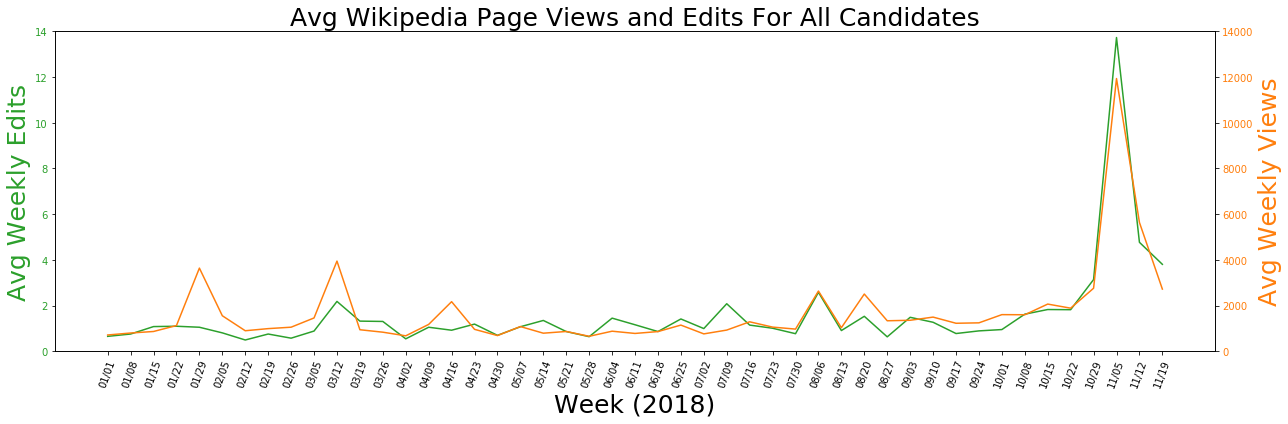

In [41]:
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)
plt.xticks(rotation=70)
plt.title("Avg Wikipedia Page Views and Edits For All Candidates", fontsize=FONTSIZE)

ax1color = 'tab:green'
ax1.tick_params(axis='y', labelcolor=ax1color)
ax1.set_xlabel('Week (2018)', fontsize=FONTSIZE)
ax1.set_ylabel('Avg Weekly Edits', color=ax1color, fontsize=FONTSIZE)
ax1.plot(weeks, Atote, color=ax1color)
ax1.set(ylim=[0, 14])

ax2 = ax1.twinx()
ax2color = 'tab:orange'
ax2.tick_params(axis='y', labelcolor=ax2color)
ax2.set_ylabel('Avg Weekly Views', color=ax2color, fontsize=FONTSIZE)
ax2.plot(weeks, Atotv, color=ax2color)
ax2.set(ylim=[0, 14000])

fig.tight_layout()
plt.show()

H1 appears to be confirmed. Pageviews and edits follow similar trends, with number of weekly views consistently being about 1000x the number of edits. There is a clear buildup before Election week (11/5) in both categories with a sharp peak on Election week.

Note that there are several peaks earlier in the year. The peaks in August seem like they are probably due to the primary elections. I investigated the first two peaks and discovered that the peak on the week of 1/29 is actually due to pageviews of a single politician, Devin Nunes, who released a widely publicized [memo](https://en.wikipedia.org/wiki/Nunes_memo) on 2/2/2018 which alleged that President Donald Trump was the target of partisan attacks by the FBI. Nunes' Wikipedia page recieved over 400,000 pageviews that week. The peak on the week of 3/12, similarly, was due to publicity following the Pennsylvania special election in which a Democrat ([Conor Lamb](https://en.wikipedia.org/wiki/Conor_Lamb)) was narrowly elected to power in a heavily Republican county, sparking media speculation about a Democratic "blue wave". 

### Q1: Do trends in Wikipedia page views and edits vary between political parties?
H1: There are similar trends between the two parties.

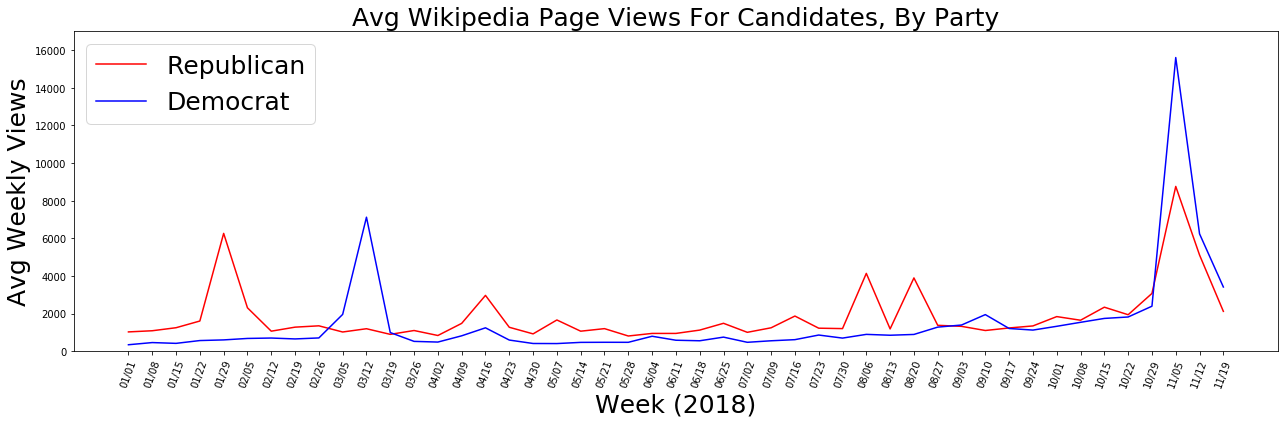

In [42]:
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)
plt.xticks(rotation=70)
plt.title("Avg Wikipedia Page Views For Candidates, By Party", fontsize=FONTSIZE)

colors = ["red", "blue"]
ax1.tick_params(axis='y')
ax1.set_xlabel('Week (2018)', fontsize=FONTSIZE)
ax1.set_ylabel('Avg Weekly Views', fontsize=FONTSIZE)
lines = []
for d, c in zip([Rtotv, Dtotv], colors):
  t, = ax1.plot(weeks, d, color=mcolors[c])
  lines.append(t)
ax1.set(ylim=[0, 17000])

plt.legend(handles=lines, labels = ["Republican", "Democrat"], fontsize=FONTSIZE)
fig.tight_layout()
plt.show()

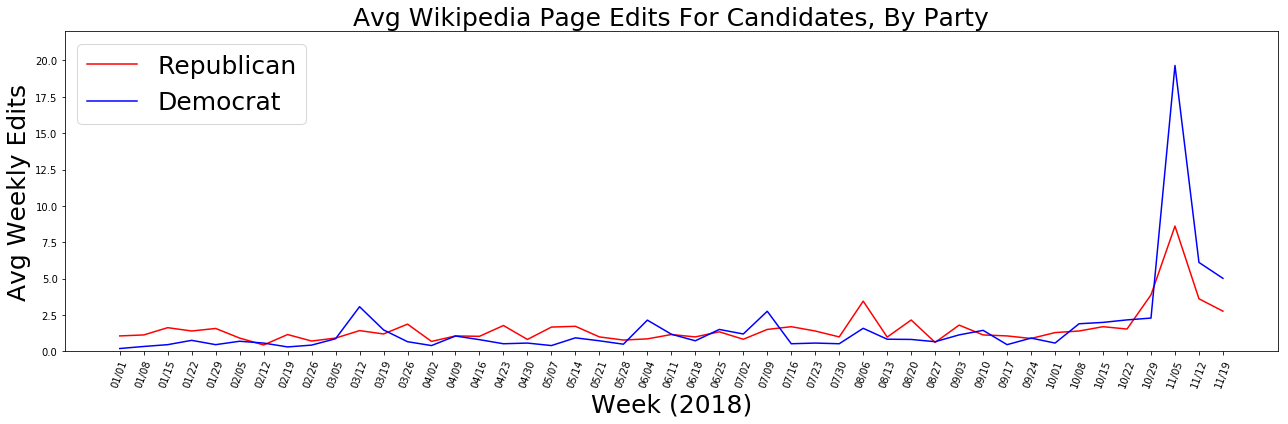

In [43]:
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)
plt.xticks(rotation=70)
plt.title("Avg Wikipedia Page Edits For Candidates, By Party", fontsize=FONTSIZE)

colors = ["red", "blue"]
ax1.tick_params(axis='y')
ax1.set_xlabel('Week (2018)', fontsize=FONTSIZE)
ax1.set_ylabel('Avg Weekly Edits', fontsize=FONTSIZE)
lines = []
for d, c in zip([Rtote, Dtote], colors):
  t, = ax1.plot(weeks, d, color=mcolors[c])
  lines.append(t)
ax1.set(ylim=[0, 22])

plt.legend(handles=lines, labels = ["Republican", "Democrat"], fontsize=FONTSIZE)
fig.tight_layout()
plt.show()

The trends between the two parties do appear to be similar; however there are some notable differences as well. Most striking is that average Wikipedia activity in general appears to be much higher for Democrats than for Republicans during election week (about 2x as many page views, and 2.5x as many edits), despite being similar throughout the year. Republicans, however, had around 4x as many weekly pageviews during the August primaries.

### Q1: Do trends in Wikipedia page views and edits vary with how contested an election is believed to be?
H1: My hypothesis is that there is a strong correlation, i.e. that elections that are perceived to be highly contested result in more page views and edits.

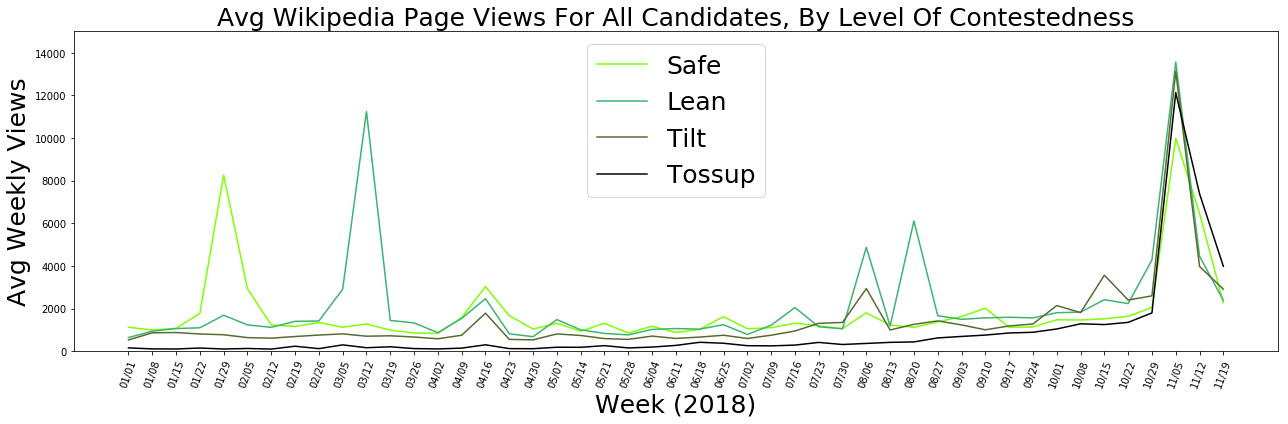

In [44]:
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)
plt.xticks(rotation=70)
plt.title("Avg Wikipedia Page Views For All Candidates, By Level Of Contestedness", fontsize=FONTSIZE)

colors = ["chartreuse", "mediumseagreen", "darkolivegreen", "black"]
ax1.tick_params(axis='y')
ax1.set_xlabel('Week (2018)', fontsize=FONTSIZE)
ax1.set_ylabel('Avg Weekly Views', fontsize=FONTSIZE)
lines = []
for d, c in zip([A1v, A2v, A3v, A4v], colors):
  t, = ax1.plot(weeks, d, color=mcolors[c])
  lines.append(t)
ax1.set(ylim=[0, 15000])

plt.legend(handles=lines, labels = CONTEST_LEVELS, fontsize=FONTSIZE)
fig.tight_layout()
plt.show()

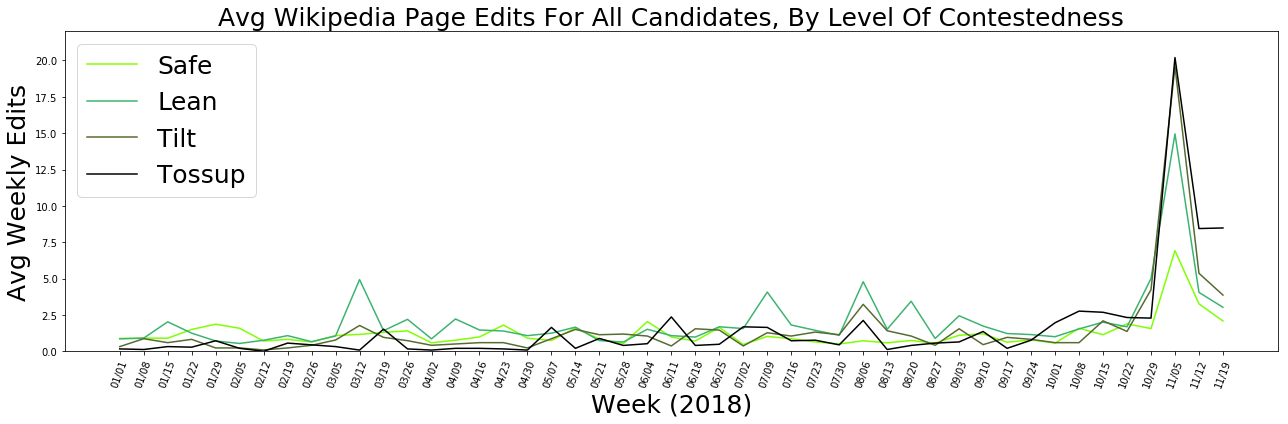

In [45]:
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)
plt.xticks(rotation=70)
plt.title("Avg Wikipedia Page Edits For All Candidates, By Level Of Contestedness", fontsize=FONTSIZE)

colors = ["chartreuse", "mediumseagreen", "darkolivegreen", "black"]
ax1.tick_params(axis='y')
ax1.set_xlabel('Week (2018)', fontsize=FONTSIZE)
ax1.set_ylabel('Avg Weekly Edits', fontsize=FONTSIZE)
lines = []
for d, c in zip([A1e, A2e, A3e, A4e], colors):
  t, = ax1.plot(weeks, d, color=mcolors[c])
  lines.append(t)
ax1.set(ylim=[0, 22])

plt.legend(handles=lines, labels = CONTEST_LEVELS, fontsize=FONTSIZE)
fig.tight_layout()
plt.show()

In this case, the data did not show a noticable difference for page views per candidate; however, there was a clear difference for page edits. Wikipedia pages for candidates in 'Tossup' races experienced on average over 20 edits during election week, while pages for candidates in 'Safe' races averaged only 6. 

# Conclusion

Overall, this study partially confirmed all three of my hypotheses. There does appear to be a well-defined trend in Wikipedia activity for candidate's pages during an election cycle, with a peak of activity corresponding to election week. Both parties do show similar trends on average, although pages for Democratic candidates were noted to have over double the average views during election week. While page views do not appear correlated with how strongly contested a race is, it appears that page edits do in fact go up for more competitive races, giving support to my hypothesis that there are attempts made during the week of an election to use Wikipedia as a political platform. 